In [1]:
import os
import warnings
import re
import random
import math
import pandas as pd
import numpy as np
import scipy
import sklearn

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from pylab import rcParams

In [4]:
feeds_df = pd.read_csv(os.getcwd() + '/Datasets/feeds_df_for_reco.csv')
feeds_df['createdAt'] = pd.to_datetime(feeds_df['createdAt'])
feeds_df['updatedAt'] = pd.to_datetime(feeds_df['updatedAt'])
feeds_df = feeds_df[~feeds_df['text'].isna()]
print(feeds_df.shape)
feeds_df.head()

(2555, 13)


,contentId,anonymous,authorId,createdAt,isActive,isDelete,points,text,type,updatedAt,resource_link,resource_videoUrl,resource_image
0,5eaa8499d9e8980022200604,False,5ea238633ae1b80048f4f43c,2020-04-30 07:56:09.909,True,False,0.222222,Balance #Negotiation Power Negotiation requir...,POST,2020-04-30 08:34:36.795,[{'url': 'https://www.linkedin.com/pulse/crash...,[],[]
1,5eabae544bc32c003663b786,False,5eabad0e9890ea0050e7c800,2020-05-01 05:06:28.767,True,False,0.235294,"Hi guys, I am a chemical Engineer. But my pass...",POST,2020-05-01 09:33:16.347,[],[],[]
2,5eaa94e911914b00283bcaf5,False,5eaa928fd9e8980022200613,2020-04-30 09:05:45.211,True,False,0.888889,@ShitalKakad Which Indian food to include in t...,QUESTION,2020-05-13 02:38:07.669,[],[],[]
3,5eaad78e11914b00283bcb25,False,5ea974f75e00240036a11833,2020-04-30 13:50:06.761,True,False,1.647059,Hello everyone. Looking forward to connect wit...,POST,2020-05-01 08:14:41.114,[],[],[]
4,5eac79d6bfe8020026a3bc63,False,5eac5a685ed505002290ca9b,2020-05-01 19:34:46.428,True,False,0.937500,Hey me Ankita ..I want to get work from home j...,POST,2020-05-17 20:33:23.220,[],[],[]


# Interactions Data

In [5]:
#interactions_df.to_csv('interactions_df.csv', index = False)
interactions_df = pd.read_csv('interactions_df.csv')
interactions_df['createdAt'] = pd.to_datetime(interactions_df['createdAt'])
interactions_df.dtypes

eventId              object
contentId            object
personId             object
createdAt    datetime64[ns]
type                 object
eventType            object
dtype: object

In [6]:
first_interaction = interactions_df.groupby(['personId', 'contentId'])['createdAt'].min().reset_index()
first_interaction['rank'] = first_interaction.groupby(['personId'])['createdAt'].rank(method="first", ascending = False)

content_count = first_interaction.groupby(['personId'])['contentId'].count().reset_index()
content_count.columns = ['personId', 'content_count']

first_interaction = pd.merge(first_interaction, content_count, how = 'left', on = ['personId'])

max_rank = first_interaction.groupby(['personId'])['rank'].max().reset_index()
max_rank.columns = ['personId', 'max_rank']

first_interaction = pd.merge(first_interaction, max_rank, how = 'left', on = ['personId'])
first_interaction['rank_proportion'] = (first_interaction['rank']/first_interaction['max_rank'])*100

first_interaction['interaction_category'] = np.where(first_interaction['content_count'] == 1, 'Single', 'Multi')

first_interaction.head()

,personId,contentId,createdAt,rank,content_count,max_rank,rank_proportion,interaction_category
0,5df38de0b2694d0016bdb71f,5df7222ed092c70016203257,2019-12-12 21:54:00,282.0,567,567.0,49.735450,Multi
1,5df38de0b2694d0016bdb71f,5df72230d092c7001620325d,2019-12-12 21:54:00,283.0,567,567.0,49.911817,Multi
2,5df38de0b2694d0016bdb71f,5df72233d092c70016203263,2019-12-12 21:54:00,284.0,567,567.0,50.088183,Multi
3,5df38de0b2694d0016bdb71f,5df72235d092c7001620326a,2019-12-12 21:54:00,285.0,567,567.0,50.264550,Multi
4,5df38de0b2694d0016bdb71f,5df72238d092c70016203271,2019-12-12 21:54:00,286.0,567,567.0,50.440917,Multi


In [7]:
first_interaction_multi = first_interaction[first_interaction['interaction_category'] == 'Multi'].copy()

def custom_train_test_func(df):
    if( (df['content_count']<=4) & (df['rank']==1.0) ):
        return('Test')
    if( (df['content_count']>4) & (df['rank_proportion']<=20.00000) & (df['rank']<=10.0) ):
        return('Test')
    else:
        return('Train')

first_interaction_multi['train_test'] = first_interaction_multi.apply(custom_train_test_func, axis=1)
#first_interaction['train_test'] = np.where((first_interaction['interaction_category']=='Multi') & (first_interaction['rank_proportion']<=33.33333), "Test", "Train")
first_interaction_multi.head(5)

,personId,contentId,createdAt,rank,content_count,max_rank,rank_proportion,interaction_category,train_test
0,5df38de0b2694d0016bdb71f,5df7222ed092c70016203257,2019-12-12 21:54:00,282.0,567,567.0,49.735450,Multi,Train
1,5df38de0b2694d0016bdb71f,5df72230d092c7001620325d,2019-12-12 21:54:00,283.0,567,567.0,49.911817,Multi,Train
2,5df38de0b2694d0016bdb71f,5df72233d092c70016203263,2019-12-12 21:54:00,284.0,567,567.0,50.088183,Multi,Train
3,5df38de0b2694d0016bdb71f,5df72235d092c7001620326a,2019-12-12 21:54:00,285.0,567,567.0,50.264550,Multi,Train
4,5df38de0b2694d0016bdb71f,5df72238d092c70016203271,2019-12-12 21:54:00,286.0,567,567.0,50.440917,Multi,Train


In [8]:
print('Train', first_interaction_multi[first_interaction_multi['train_test']=='Train'].shape)
print('Test', first_interaction_multi[first_interaction_multi['train_test']=='Test'].shape)

Train (7450, 9)
Test (1490, 9)


# Data Wrangling

In [9]:
event_type_strength = {
#   'VIEW': 1.0,
   'LIKE': 2.0, 
   'BOOKMARK': 2.5, 
#   'FOLLOW': 3.0,
   'COMMENT': 4.0,
    'SUBCOMMENT': 4.0,
    'CREATE POST':5
}

interactions_df['eventStrength'] = interactions_df['eventType'].apply(lambda x: event_type_strength[x])

In [10]:
users_interactions_count_df = interactions_df.groupby(['personId', 'contentId']).size().groupby('personId').size()
print('# users: %d' % len(users_interactions_count_df))
users_with_1_interactions_df = users_interactions_count_df[users_interactions_count_df == 1].reset_index()[['personId']]
print('# users with 1 interactions: %d' % len(users_with_1_interactions_df))
users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 2].reset_index()[['personId']]
print('# users with at least 2 interactions: %d' % len(users_with_enough_interactions_df))

# users: 2180
# users with 1 interactions: 1283
# users with at least 2 interactions: 897


In [11]:
print('# of interactions: %d' % len(interactions_df))
interactions_from_multi_inter_users_df = interactions_df.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'personId',
               right_on = 'personId')
print('# of interactions from users with at least 2 interactions: %d' % len(interactions_from_multi_inter_users_df))

# of interactions: 13639
# of interactions from users with at least 2 interactions: 11787


In [12]:
print('# of interactions: %d' % len(interactions_df))
interactions_from_single_inter_users_df = interactions_df.merge(users_with_1_interactions_df, 
               how = 'right',
               left_on = 'personId',
               right_on = 'personId')
print('# of interactions from users with 1 interaction: %d' % len(interactions_from_single_inter_users_df))

# of interactions: 13639
# of interactions from users with 1 interaction: 1852


In [13]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_multi_df = interactions_from_multi_inter_users_df \
                    .groupby(['personId', 'contentId'])['eventStrength'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_multi_df))
interactions_multi_df.head()

# of unique user/item interactions: 8940


,personId,contentId,eventStrength
0,5df38de0b2694d0016bdb71f,5df7222ed092c70016203257,2.584963
1,5df38de0b2694d0016bdb71f,5df72230d092c7001620325d,2.584963
2,5df38de0b2694d0016bdb71f,5df72233d092c70016203263,2.584963
3,5df38de0b2694d0016bdb71f,5df72235d092c7001620326a,2.584963
4,5df38de0b2694d0016bdb71f,5df72238d092c70016203271,2.584963


In [14]:
interactions_single_df = interactions_from_single_inter_users_df \
                    .groupby(['personId', 'contentId'])['eventStrength'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_single_df))
interactions_single_df.head()

# of unique user/item interactions: 1283


,personId,contentId,eventStrength
0,5df4582e7e4ea600161b8e75,5df45cdc7e4ea600161b8f0f,2.584963
1,5df459377e4ea600161b8e94,5df45c6e7e4ea600161b8efb,2.584963
2,5df45a5c7e4ea600161b8ebd,5df45e207e4ea600161b8f49,2.584963
3,5df45eea7e4ea600161b8f6f,5df45fed7e4ea600161b8fb0,2.584963
4,5df45feb7e4ea600161b8fad,5df461f77e4ea600161b8ff6,2.584963


In [15]:
full_interaction_df = interactions_multi_df.append(interactions_single_df)
full_interaction_df.head()

,personId,contentId,eventStrength
0,5df38de0b2694d0016bdb71f,5df7222ed092c70016203257,2.584963
1,5df38de0b2694d0016bdb71f,5df72230d092c7001620325d,2.584963
2,5df38de0b2694d0016bdb71f,5df72233d092c70016203263,2.584963
3,5df38de0b2694d0016bdb71f,5df72235d092c7001620326a,2.584963
4,5df38de0b2694d0016bdb71f,5df72238d092c70016203271,2.584963


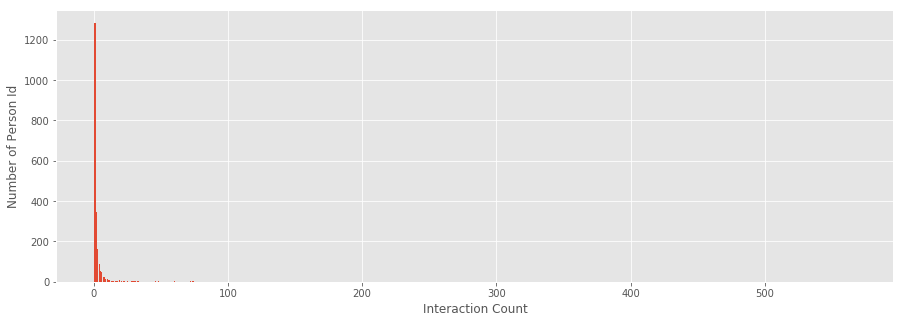

In [16]:
user_interaction_category = users_interactions_count_df.reset_index()
user_interaction_category.columns = ['personId', 'interaction_count']
user_interaction_category.head()

user_interaction_count_summary = user_interaction_category.groupby(['interaction_count'])['personId'].count().reset_index()

%matplotlib inline
rcParams['figure.figsize'] = 15, 5
plt.style.use('ggplot')
plt.bar(user_interaction_count_summary['interaction_count'], user_interaction_count_summary['personId'])
plt.xlabel("Interaction Count")
plt.ylabel("Number of Person Id")
plt.show()

In [17]:
def interaction_category_func(df):
    if(df['interaction_count'] == 1):
        return("1")
    if(df['interaction_count'] == 2):
        return("2")
    if((df['interaction_count'] > 2) & (df['interaction_count'] <= 5)):
        return("3 to 5")
    if((df['interaction_count'] > 5) & (df['interaction_count'] <= 10)):
        return("6 to 10")
    if((df['interaction_count'] > 10) & (df['interaction_count'] <= 50)):
        return("11 to 50")
    if(df['interaction_count'] > 50):
        return("More than 50")
    else:
        return(np.nan)

def interaction_ordering_func(df):
    if(df['interaction_count'] == 1):
        return(1)
    if(df['interaction_count'] == 2):
        return(2)
    if((df['interaction_count'] > 2) & (df['interaction_count'] <= 5)):
        return(3)
    if((df['interaction_count'] > 5) & (df['interaction_count'] <= 10)):
        return(4)
    if((df['interaction_count'] > 10) & (df['interaction_count'] <= 50)):
        return(5)
    if(df['interaction_count'] > 50):
        return(6)
    else:
        return(np.nan)
    
user_interaction_category['interaction_category'] = user_interaction_category.apply(interaction_category_func, axis = 1)
user_interaction_category['order'] = user_interaction_category.apply(interaction_ordering_func, axis = 1)
user_interaction_category.groupby(['order', 'interaction_category'])['personId'].count().reset_index()

,order,interaction_category,personId
0,1,1,1283
1,2,2,345
2,3,3 to 5,307
3,4,6 to 10,121
4,5,11 to 50,88
5,6,More than 50,36


# Evaluation

In [18]:
## Time Bound Sampling

interactions_multi_df_time = pd.merge(interactions_multi_df, first_interaction_multi[['personId', 'contentId', 'train_test']], how = 'left', on = ['personId', 'contentId'])
interactions_multi_df_time.head()

interactions_multi_train_df = interactions_multi_df_time[interactions_multi_df_time['train_test'] == 'Train']
interactions_multi_train_df = interactions_multi_train_df.drop(['train_test'], axis=1)

interactions_multi_test_df = interactions_multi_df_time[interactions_multi_df_time['train_test'] == 'Test']
interactions_multi_test_df = interactions_multi_test_df.drop(['train_test'], axis=1)

print('# interactions on Multi Train set: %d' % len(interactions_multi_train_df))
print('# interactions on Multi Test set (These are old customers with History): %d' % len(interactions_multi_test_df))


interactions_single_df_time = pd.merge(interactions_single_df, first_interaction[['personId', 'contentId', 'createdAt']], how = 'left', on = ['personId', 'contentId'])
interactions_single_df_time.head()

interactions_single_train_df = interactions_single_df_time[interactions_single_df_time['createdAt'] <= pd.to_datetime('2020-05-10')].copy()
interactions_single_train_df = interactions_single_train_df.drop(['createdAt'], axis=1)
interactions_single_test_df = interactions_single_df_time[interactions_single_df_time['createdAt'] > pd.to_datetime('2020-05-10')].copy()
interactions_single_test_df = interactions_single_test_df.drop(['createdAt'], axis=1)
print('# interactions on Single Train set: %d' % len(interactions_single_train_df))
print('# interactions on Single Test set (These are new customers with no History): %d' % len(interactions_single_test_df))


# interactions on Multi Train set: 7450
# interactions on Multi Test set (These are old customers with History): 1490
# interactions on Single Train set: 1050
# interactions on Single Test set (These are new customers with no History): 233


In [19]:
## Random Sampling
# Take 20% random content as Test. 
# However perform stratified sampling on multi interaction user vs simple sampling for single interaction users
interactions_multi_train_df, interactions_multi_test_df = train_test_split(interactions_multi_df,
                                   stratify=interactions_multi_df['personId'], 
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Multi Train set: %d' % len(interactions_multi_train_df))
print('# interactions on Multi Test set (These are old customers with History): %d' % len(interactions_multi_test_df))

interactions_single_train_df, interactions_single_test_df = train_test_split(interactions_single_df,
                                   #stratify=interactions_multi_df['personId'], 
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Single Train set: %d' % len(interactions_single_train_df))
print('# interactions on Single Test set (These are new customers with no History): %d' % len(interactions_single_test_df))

# interactions on Multi Train set: 7152
# interactions on Multi Test set (These are old customers with History): 1788
# interactions on Single Train set: 1026
# interactions on Single Test set (These are new customers with no History): 257


In [20]:
#For standardisation of accuracy comparison across users limit the test case content to max 10 for each user
for_N_test_case = interactions_multi_test_df.copy()
for_N_test_case['rank'] = for_N_test_case.groupby(['personId'])['contentId'].apply(lambda x: x.rank())
for_N_test_case = for_N_test_case.sort_values(['personId', 'rank'], ascending = [True, True])

N_test_cases = for_N_test_case[for_N_test_case['rank']<=10].copy()
add_rest_to_train = for_N_test_case[for_N_test_case['rank']>10].copy()

N_test_cases = N_test_cases.drop(['rank'], axis=1)
add_rest_to_train = add_rest_to_train.drop(['rank'], axis=1)

print("N_test_cases: ", N_test_cases.shape)
print("add_rest_to_train: ", add_rest_to_train.shape)

N_test_cases:  (1274, 3)
add_rest_to_train:  (514, 3)


In [21]:
interactions_multi_train_df = interactions_multi_train_df.append(add_rest_to_train)
interactions_multi_test_df = N_test_cases

In [22]:
print('# interactions on Multi Train set: %d' % len(interactions_multi_train_df))
print('# interactions on Multi Test set (These are old customers with History): %d' % len(interactions_multi_test_df))

# interactions on Multi Train set: 7666
# interactions on Multi Test set (These are old customers with History): 1274


In [23]:
interactions_train_df = interactions_multi_train_df.append(interactions_single_train_df)
interactions_test_df = interactions_multi_test_df.append(interactions_single_test_df)

In [24]:
#Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = full_interaction_df.set_index('personId')
interactions_train_indexed_df = interactions_train_df.set_index('personId')
interactions_test_indexed_df = interactions_test_df.set_index('personId')
interactions_single_train_indexed_df = interactions_single_train_df.set_index('personId')
interactions_single_test_indexed_df = interactions_single_test_df.set_index('personId')
interactions_multi_train_indexed_df = interactions_multi_train_df.set_index('personId')

In [25]:
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

In [26]:
def get_items_interacted(person_id, interactions_df):
    # Get the user's data and merge in the movie information.
    if(((pd.Series(person_id).isin(pd.Series(interactions_df.index.unique().to_list()))) == True)[0]):
        interacted_items = interactions_df.loc[person_id]['contentId']
        return(set(interacted_items if type(interacted_items) == pd.Series else [interacted_items]))
    else:
        interacted_items = set()
        return(interacted_items)
    

In [27]:
def get_not_interacted_items_sample(person_id, sample_size, seed=42):
    interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
    all_items = set(feeds_df['contentId'])
    non_interacted_items = all_items - interacted_items

    random.seed(seed)
    non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
    return set(non_interacted_items_sample)

In [28]:
def _verify_hit_top_n(item_id, recommended_items, topn):
    try:
        index = next(i for i, c in enumerate(recommended_items) if c == item_id)
    except:
        index = -1
    hit = int(index in range(0, topn))
    return hit, index

In [29]:
#Customisation
def evaluate_model_for_user(model, person_id):
    #Getting the items in test set
    interacted_values_testset = interactions_test_indexed_df.loc[person_id]
    if type(interacted_values_testset['contentId']) == pd.Series:
        person_interacted_items_testset = set(interacted_values_testset['contentId'])
    else:
        person_interacted_items_testset = set([interacted_values_testset['contentId']])  
    interacted_items_count_testset = len(person_interacted_items_testset) 
    
    #Getting a ranked recommendation list from a model for a given user
    person_recs_df = model.recommend_items(person_id, 
                                         items_to_ignore=get_items_interacted(person_id, 
                                         interactions_train_indexed_df), 
                                         topn=1000000000)
    person_recs_df['personId'] = person_id
    top_100_reco = person_recs_df[0:100]
    
    hits_at_5_count = 0
    hits_at_10_count = 0
    #For each item the user has interacted in test set
    for item_id in person_interacted_items_testset:
        #Getting a random sample (100) items the user has not interacted 
        #(to represent items that are assumed to be no relevant to the user)
        non_interacted_items_sample = get_not_interacted_items_sample(person_id, 
                                                      sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                      seed=int(re.sub(r'[a-zA-Z]', r'', item_id))%(2**32))

        #Combining the current interacted item with the 100 random items
        items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

        #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
        valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)]                    
        valid_recs = valid_recs_df['contentId'].values
        
        #Verifying if the current interacted item is among the Top-N recommended items
        hit_at_5, index_at_5 = _verify_hit_top_n(item_id, valid_recs, 5)
        hits_at_5_count += hit_at_5
        hit_at_10, index_at_10 = _verify_hit_top_n(item_id, valid_recs, 10)
        hits_at_10_count += hit_at_10
        

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
    hits_at_all_count = sum(pd.Series(list(person_interacted_items_testset)).isin(top_100_reco['contentId']))
    
    recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
    recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)
    recall_at_all = hits_at_all_count / float(interacted_items_count_testset)

    person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'hits@all_count':hits_at_all_count,
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10,
                          'recall@all': recall_at_all,
                          'model_name': model.get_model_name()}
    return person_metrics, person_recs_df[0:10]

In [30]:
#Customisation
def evaluate_model(model, pop_model):
    #print('Running evaluation for users')
    people_metrics = []
    reco_list = pd.DataFrame(columns = ['contentId', 'eventStrength', 'createdAt', 'time_since_post', 'recency_rank', 'personId'])
    zero_recos = 0
    for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
        #if idx % 100 == 0 and idx > 0:
        #    print('%d users processed' % idx)
        #print(person_id)
        if((pd.Series(person_id).isin(interactions_single_test_indexed_df.index)[0] == True) | (pd.Series(person_id).isin(interactions_multi_train_indexed_df.index)[0] == False)):
            person_metrics, rec_list = evaluate_model_for_user(pop_model, person_id)
        else:
            person_metrics, rec_list = evaluate_model_for_user(model, person_id)
        person_metrics['_person_id'] = person_id
        people_metrics.append(person_metrics)
        reco_list = reco_list.append(rec_list)
        
        if(rec_list.shape[0] == 0):
            zero_recos = zero_recos + 1
            
    print('%d users processed' % idx)
    print('%d person with zero recos' % zero_recos)

    detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
    global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
    global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
    global_recall_at_all = detailed_results_df['hits@all_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
    global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10,
                        'recall@all': global_recall_at_all}
    
    
    return global_metrics, detailed_results_df, reco_list

In [31]:
last_interaction_in_train = pd.merge(interactions_train_df, first_interaction[['personId', 'contentId', 'createdAt']], how = 'left', on = ['personId', 'contentId'])
last_interaction_in_train = last_interaction_in_train.rename(columns = {'createdAt':'last_interaction_dt'})
last_interaction_in_train.head()

,personId,contentId,eventStrength,last_interaction_dt
0,5e809291b0854d0031972a19,5eb6964140ca75004c486c5f,2.584963,2020-05-09 11:38:41.061
1,5e857a618d7ef3003f343566,5e857bdd16ed0d002271e051,2.584963,2020-04-02 05:45:01.241
2,5ea16fe7b014c600468f0381,5ea17116287ece004c6f7a00,2.584963,2020-04-23 10:42:30.579
3,5e892b7820538600299ea864,5e891e8b0345e700300572f5,2.321928,2020-04-05 01:03:40.178
4,5df45e777e4ea600161b8f62,5ea0be43fc66110044584c4d,2.321928,2020-04-23 07:27:37.410


In [32]:
recency_df = feeds_df[['contentId', 'createdAt']].copy()
recency_df['time_since_post'] = recency_df['createdAt'].max() - recency_df['createdAt']
recency_df = recency_df.sort_values(['time_since_post'], ascending=True)
recency_df['recency_rank'] = list(range(recency_df.shape[0]))
print(recency_df.shape)
recency_df.head()

(2555, 4)


,contentId,createdAt,time_since_post,recency_rank
556,5ec280cec93e790022898ecd,2020-05-18 12:34:22.049,00:00:00,0
523,5ec27d23c93e790022898ec0,2020-05-18 12:18:43.799,00:15:38.250000,1
366,5ec27be54482a4002808c68f,2020-05-18 12:13:25.823,00:20:56.226000,2
540,5ec279f44482a4002808c68d,2020-05-18 12:05:08.660,00:29:13.389000,3
522,5ec27214c93e790022898e8b,2020-05-18 11:31:32.789,01:02:49.260000,4


In [33]:
#def recency_of_recommendation_func(all_recommendations, person_id):
#    recommendation_with_recency = pd.merge(all_recommendations, recency_df[['contentId', 'createdAt', 'time_since_post', 'recency_rank']], how = 'left', on = 'contentId')
#        
#    if(pd.Series(person_id).isin(last_interaction_in_train['personId'])[0]):
#        max_date = last_interaction_in_train[last_interaction_in_train['personId'] == person_id]['last_interaction_dt'].max()
#        recommendation_with_recency = recommendation_with_recency[recommendation_with_recency['createdAt'] > max_date]
#    else:
#        recommendation_with_recency = recommendation_with_recency[recommendation_with_recency['recency_rank']<=800]
#    return(recommendation_with_recency)

In [34]:
def recency_of_recommendation_func(all_recommendations, person_id):
    recommendation_with_recency = pd.merge(all_recommendations, recency_df[['contentId', 'createdAt', 'time_since_post', 'recency_rank']], how = 'left', on = 'contentId')
    recommendation_with_recency = recommendation_with_recency[recommendation_with_recency['recency_rank']<=800]
    return(recommendation_with_recency)

# Popularity Model

In [35]:
#For popularity use the entire set consisting of single interaction data as well as multiple interaction
full_interaction_df = interactions_multi_df.append(interactions_single_df)
full_interaction_df.head()
#Computes the most popular items
item_popularity_df = full_interaction_df.groupby('contentId')['eventStrength'].sum().sort_values(ascending=False).reset_index()
item_popularity_df.head(10)

,contentId,eventStrength
0,5eb4f43d63c2df0022d975b8,141.070747
1,5ebb8db54b04f6003dd86570,140.049821
2,5e782cd3ea7e440022515910,117.255353
3,5ea2c5e5d4abf40029d88e2f,110.661180
4,5eb64ff240ca75004c486c14,81.650041
5,5eb39dc7854ebb0022622aa0,73.061326
6,5eb78f0117e19d00491830ab,65.920599
7,5eb23edc7056fb002fab0c65,65.753619
8,5ea153885738810038814fcf,61.772765
9,5eafced11fd841002e2c9c15,57.071194


In [36]:
class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['contentId'].isin(items_to_ignore)] \
                               .sort_values('eventStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['eventStrength', 'contentId']]
        
        #recommendations_df = recency_of_recommendation_func(recommendations_df, user_id)


        return recommendations_df
    
popularity_model = PopularityRecommender(item_popularity_df, feeds_df)

In [37]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [38]:
print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df, full_reco_list = evaluate_model(popularity_model, popularity_model)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head()

Evaluating Popularity recommendation model...
832 users processed
0 person with zero recos

Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.1868060091443501, 'recall@10': 0.2984977139124755, 'recall@all': 0.16721097322011758}


,_person_id,hits@10_count,hits@5_count,hits@all_count,interacted_count,model_name,recall@10,recall@5,recall@all
0,5df38de0b2694d0016bdb71f,0,0,0,10,Popularity,0.0,0.0,0.0
41,5df467277e4ea600161b9109,2,2,2,10,Popularity,0.2,0.2,0.2
28,5df461787e4ea600161b8fea,4,3,3,10,Popularity,0.4,0.3,0.3
61,5df475827e4ea600161b9344,3,1,1,10,Popularity,0.3,0.1,0.1
30,5df4623c7e4ea600161b8fff,2,2,0,10,Popularity,0.2,0.2,0.0


In [39]:
full_reco_list.head()

,contentId,createdAt,eventStrength,personId,recency_rank,time_since_post
8,5ea153885738810038814fcf,NaN,61.772765,5df38de0b2694d0016bdb71f,NaN,NaN
10,5e95945b41a162004c575518,NaN,56.989595,5df38de0b2694d0016bdb71f,NaN,NaN
13,5e7ee7998735d5002991de15,NaN,46.966708,5df38de0b2694d0016bdb71f,NaN,NaN
14,5e958b00bdca200024b49ecb,NaN,46.186693,5df38de0b2694d0016bdb71f,NaN,NaN
16,5e05965154f7880016b75a5f,NaN,44.142292,5df38de0b2694d0016bdb71f,NaN,NaN


In [40]:
print("Coverage:", full_reco_list['contentId'].nunique() / feeds_df['contentId'].nunique())

Coverage: 0.009784735812133072


In [41]:
def summary_results_func(detailed_results_df, mod_global_metrics):
    detailed_results_df = pd.merge(detailed_results_df, user_interaction_category, how = 'left', left_on = '_person_id', right_on = 'personId')
    detailed_results_df = detailed_results_df.drop(['personId'], axis = 1)
    mod_summary = detailed_results_df.groupby(['order', 'interaction_category']).agg({'_person_id':'count', 'recall@10':'mean', 'recall@5':'mean', 'recall@all':'mean', 'interacted_count':'mean'}).reset_index()
    mod_summary = mod_summary.rename(columns = {'interacted_count':'interacted_in_test_avg'})
    
    overall_summary = pd.DataFrame(index = [0], columns=mod_summary.columns)
    overall_summary['order'] = mod_summary['order'].max()+1
    overall_summary['interaction_category'] = 'Total'
    overall_summary['_person_id'] = mod_summary['_person_id'].sum()
    overall_summary['recall@10'] = mod_global_metrics['recall@10']
    overall_summary['recall@5'] = mod_global_metrics['recall@5']
    overall_summary['recall@all'] = mod_global_metrics['recall@all']
    overall_summary['interacted_in_test_avg'] = sum(mod_summary['interacted_in_test_avg']*mod_summary['_person_id'])/sum(mod_summary['_person_id'])
    final_mod_summary = mod_summary.append(overall_summary)
    return(final_mod_summary)


In [42]:
pop_summary = summary_results_func(pop_detailed_results_df, pop_global_metrics)
pop_summary

,order,interaction_category,_person_id,recall@10,recall@5,recall@all,interacted_in_test_avg
0,1,1,257,0.303502,0.241245,0.229572,1.000000
1,2,2,24,0.333333,0.291667,0.250000,1.000000
2,3,3 to 5,307,0.286645,0.208469,0.182410,1.000000
3,4,6 to 10,121,0.359504,0.223140,0.202479,1.595041
4,5,11 to 50,88,0.268290,0.145148,0.146677,4.431818
5,6,More than 50,36,0.316667,0.161111,0.122222,10.000000
0,7,Total,833,0.298498,0.186806,0.167211,1.837935


#### Popularity Demo

In [44]:
pop_detailed_results_df[pop_detailed_results_df['recall@all'] == 0.4]

,_person_id,hits@10_count,hits@5_count,hits@all_count,interacted_count,model_name,recall@10,recall@5,recall@all
115,5df76af011788b0016813414,5,4,4,10,Popularity,0.5,0.4,0.4
435,5ea2986ab32067003d031ef4,2,2,2,5,Popularity,0.4,0.4,0.4


In [45]:
u_id = '5df76af011788b0016813414'
user_rec = popularity_model.recommend_items(u_id, items_to_ignore=get_items_interacted(u_id, 
                                         interactions_train_indexed_df), 
                                         topn=100)
user_rec = pd.merge(user_rec, feeds_df[['contentId', 'text']], how = 'left', on = 'contentId')
user_rec

,contentId,eventStrength,text
0,5eb4f43d63c2df0022d975b8,141.070747,MOTHER'S DAY CONTEST - THIRD DAY QUESTION! In ...
1,5ea2c5e5d4abf40029d88e2f,110.661180,Share your favourite book with the Community. ...
2,5eb64ff240ca75004c486c14,81.650041,MOTHER'S DAY CONTEST - FOURTH DAY QUESTION! In...
3,5eb39dc7854ebb0022622aa0,73.061326,MOTHER'S DAY CONTEST - SECOND DAY QUESTION! In...
4,5ea153885738810038814fcf,61.772765,Hi!I need some advice. I have been seeing dome...
5,5ea7d8ed905def0034f7a93c,55.490347,@Ojjasvi @PoonamTalukdar @PreetieWalia @Madhus...
6,5e7ee7998735d5002991de15,46.966708,Are there any bloggers around who would like t...
7,5e958b00bdca200024b49ecb,46.186693,Hello Everyone! I'm new to this community. The...
8,5e05965154f7880016b75a5f,44.142292,These cold winter mornings have got me missing...
9,5eb3fd91e38ea600369006ae,43.136621,"Are you a yoga teacher, physiotherapist, psych..."


In [46]:
user_rec['text'][2]

"MOTHER'S DAY CONTEST - FOURTH DAY QUESTION! In the run up to Mother's Day, we are hosting a contest here!  Share your answer to our Mother's Day question today and tomorrow.  The best answer of the day will win an Amazon egift card! Type your answer in the comments section below with the hashtag - #MothersDay"

In [47]:
user_rec['match']=1
user_rec = user_rec.rename(columns = {'eventStrength':'reco_Strength'})

In [48]:
users_test_case = interactions_test_indexed_df[interactions_test_indexed_df.index == u_id]
users_test_case = pd.merge(users_test_case, feeds_df[['contentId', 'text']], how = 'left', on = 'contentId')
users_test_case = pd.merge(users_test_case, user_rec[['contentId', 'match', 'reco_Strength']], how = 'left', on = 'contentId')
users_test_case

,contentId,eventStrength,text,match,reco_Strength
0,5dfb23eef1289d0016d3559a,3.584963,"Hi guys, I will be hosting a Goal Setting work...",NaN,NaN
1,5e7269f9b282850016b64080,2.807355,After spending 5 years in Singapore I moved to...,NaN,NaN
2,5e774f6bd7ca980016baf4ed,2.807355,Hello Kool KanyasI want to use this work from ...,1.0,31.781523
3,5e77be6aea7e4400225158f5,1.584963,I have just finished my website and I will be ...,1.0,23.452839
4,5e7836edea7e44002251591f,1.584963,Hello everyone!TL;DR this pandemic might affec...,1.0,33.834262
5,5e787e4aea07030028701e67,1.584963,Hey! I am new here. (I guess everyone is :P :...,NaN,NaN
6,5e7991ad704a5d0022e026b3,4.169925,"Hi everyone, I recently came across a few peop...",NaN,NaN
7,5e799917704a5d0022e026e0,2.807355,"Times are tough, but we're in this together. I...",1.0,28.593948
8,5e7adea05e2628002444fba1,4.169925,Good morning #Koolkanyas! I would like to shar...,NaN,NaN
9,5e7da7392b1c62002213200b,1.584963,Hello to the community! I'm keen on starting a...,NaN,NaN


In [49]:
users_train_case = interactions_train_indexed_df[interactions_train_indexed_df.index == u_id]
users_train_case = pd.merge(users_train_case, feeds_df[['contentId', 'text']], how = 'left', on = 'contentId')
users_train_case

,contentId,eventStrength,text
0,5e830c5012150300454b4e77,2.807355,"Hello All,I am Minali Zaveri, a pastry chef ba..."
1,5e726837b282850016b6407f,1.584963,"Me Time , Do we all get some me-time during th..."
2,5e8c6b90618bcb00290c99e7,3.169925,"Hi All,This is Sulekha. I want to explore myse..."
3,5e7d98fa49d9550024126a51,2.807355,Guys enjoy ur life in all the ways...in this l...
4,5eb197a3a3fe59004b6651ab,1.584963,"Hi, I am Sukarna, web content writer by profes..."
5,5e25580948822c0016d3c934,1.584963,Hi everyone. I've been invited by Kool Kanya ...
6,5e94aff18c1035002810a261,2.807355,I created this fun foodart live on instagram t...
7,5e8d5d3ae24cfa002a2319e0,4.459432,Hello everyone! After conducting a survey and...
8,5e94c6ff9043d40037bf1b97,1.584963,#ThanksAll #VoiceOfMyDiary #koolkanyas #HearM...
9,5ec10d5082d9c7002979716f,2.321928,"Hi All, I am willing to start as a freelance..."


# Content-Based Filtering model

In [50]:
#Ignoring stopwords (words with no semantics) from English and Portuguese (as we have a corpus with mixed languages)
stopwords_list = stopwords.words('english')

#Trains a model whose vectors size is 5000, composed by the main unigrams and bigrams found in the corpus, ignoring stopwords
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords_list)

item_ids = feeds_df['contentId'].tolist()
tfidf_matrix = vectorizer.fit_transform(feeds_df['text'])
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

<2555x1717 sparse matrix of type '<class 'numpy.float64'>'
	with 51766 stored elements in Compressed Sparse Row format>

In [51]:
def get_item_profile(item_id):
    #print(item_id)
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    #print(ids)
    if(isinstance(ids, str)):
        ids = [ids]
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    #print(person_id)
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['contentId'])
    
    user_item_strengths = np.array(interactions_person_df['eventStrength']).reshape(-1,1)
    #Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    return user_profile_norm

def build_users_profiles(): 
    interactions_indexed_df = interactions_train_df[interactions_train_df['contentId'] \
                                                   .isin(feeds_df['contentId'])].set_index('personId')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        #print(person_id)
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

In [52]:
user_profiles = build_users_profiles()
len(user_profiles)

1923

In [53]:
myprofile = user_profiles['5e85f9294841b100281d4709']
print(myprofile.shape)
pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        user_profiles['5e85f9294841b100281d4709'].flatten().tolist()), key=lambda x: -x[1])[:20],
             columns=['token', 'relevance'])

(1, 1717)


,token,relevance
0,iamstri,0.381824
1,freelancers,0.218867
2,remotejobs,0.191450
3,freelancejobs,0.181355
4,womenentrepreneur,0.142191
5,work,0.140431
6,career,0.130588
7,freelancing,0.129973
8,looking,0.123536
9,women,0.116366


In [54]:
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        #Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['contentId', 'recStrength']) \
                                    .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId']]
        
        #recommendations_df = recency_of_recommendation_func(recommendations_df, user_id)
        
        return recommendations_df
    
content_based_recommender_model = ContentBasedRecommender(feeds_df)

In [55]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [56]:
print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df, full_reco_list = evaluate_model(content_based_recommender_model, popularity_model)
print('\nGlobal metrics:\n%s' % cb_global_metrics)
cb_detailed_results_df.head(10)

Evaluating Content-Based Filtering model...
832 users processed
0 person with zero recos

Global metrics:
{'modelName': 'Content-Based', 'recall@5': 0.19790986283474854, 'recall@10': 0.2606139777922926, 'recall@all': 0.17700849118223383}


,_person_id,hits@10_count,hits@5_count,hits@all_count,interacted_count,model_name,recall@10,recall@5,recall@all
0,5df38de0b2694d0016bdb71f,3,2,2,10,Content-Based,0.3,0.2,0.2
41,5df467277e4ea600161b9109,1,1,1,10,Content-Based,0.1,0.1,0.1
28,5df461787e4ea600161b8fea,2,1,1,10,Content-Based,0.2,0.1,0.1
61,5df475827e4ea600161b9344,2,0,0,10,Content-Based,0.2,0.0,0.0
30,5df4623c7e4ea600161b8fff,0,0,0,10,Content-Based,0.0,0.0,0.0
106,5df73975d092c70016203c1f,0,0,0,10,Content-Based,0.0,0.0,0.0
182,5e7c74cc5e7b37002254c151,5,5,5,10,Content-Based,0.5,0.5,0.5
35,5df464cd7e4ea600161b907f,1,1,0,10,Content-Based,0.1,0.1,0.0
183,5e7c79d8ad47950024ffd1db,3,3,2,10,Content-Based,0.3,0.3,0.2
109,5df74455d092c70016203cc2,2,2,0,10,Content-Based,0.2,0.2,0.0


In [57]:
temp = cb_detailed_results_df[cb_detailed_results_df['model_name'] != 'Popularity']
print(temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")

temp = cb_detailed_results_df[cb_detailed_results_df['model_name'] == 'Popularity']
print(temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")

0.2519623233908948 for  576  Users
0.3035019455252918 for  257  Users


In [58]:
cb_summary = summary_results_func(cb_detailed_results_df, cb_global_metrics)
cb_summary

,order,interaction_category,_person_id,recall@10,recall@5,recall@all,interacted_in_test_avg
0,1,1,257,0.303502,0.241245,0.229572,1.000000
1,2,2,24,0.291667,0.291667,0.250000,1.000000
2,3,3 to 5,307,0.312704,0.257329,0.218241,1.000000
3,4,6 to 10,121,0.268595,0.214876,0.202479,1.595041
4,5,11 to 50,88,0.253111,0.193380,0.176114,4.431818
5,6,More than 50,36,0.208333,0.133333,0.113889,10.000000
0,7,Total,833,0.260614,0.197910,0.177008,1.837935


In [59]:
print("Coverage:", full_reco_list['contentId'].nunique() / feeds_df['contentId'].nunique())

Coverage: 0.6810176125244618


In [60]:
full_reco_list.head()

,contentId,createdAt,eventStrength,personId,recStrength,recency_rank,time_since_post
0,5df7228ed092c70016203353,NaN,NaN,5df38de0b2694d0016bdb71f,0.533923,NaN,NaN
1,5e9abd2768a0cd002f9f0ccc,NaN,NaN,5df38de0b2694d0016bdb71f,0.305291,NaN,NaN
2,5e7df03ec3f6090022544818,NaN,NaN,5df38de0b2694d0016bdb71f,0.260384,NaN,NaN
3,5e7b4cd8a4f3370022656607,NaN,NaN,5df38de0b2694d0016bdb71f,0.260099,NaN,NaN
4,5e3d5b6e4a2b520016102136,NaN,NaN,5df38de0b2694d0016bdb71f,0.257194,NaN,NaN


#### Content Based Demo

In [61]:
cb_detailed_results_df[cb_detailed_results_df['recall@all'] == 0.6]

,_person_id,hits@10_count,hits@5_count,hits@all_count,interacted_count,model_name,recall@10,recall@5,recall@all
293,5e85f9294841b100281d4709,7,7,6,10,Content-Based,0.7,0.7,0.6


In [62]:
u_id = '5e85f9294841b100281d4709'
user_rec = content_based_recommender_model.recommend_items(u_id, items_to_ignore=get_items_interacted(u_id, 
                                         interactions_train_indexed_df), 
                                         topn=100)
user_rec = pd.merge(user_rec, feeds_df[['contentId', 'text']], how = 'left', on = 'contentId')
user_rec

,contentId,recStrength,text
0,5e86b8929a87ef004b1830d2,0.331728,Did you know that Freelancers actually work a ...
1,5e8aa608b0c1e80028aa0bb2,0.311062,When you support a small local business you ar...
2,5e9aa495860024002847836b,0.309572,Freelancing can be lucrative to women for more...
3,5e976b9895de6500398dda17,0.302181,Hi everyone! \nI want to first thank everyone ...
4,5e95de08187620003084f0b9,0.272769,Hi all...it's great to find a platform that wi...
5,5ea32f9ec85c020045ba0109,0.265291,Hi guys. I'm looking to get my career back on...
6,5e9ff3b8e7247400305a1a21,0.254402,"@Reshma KulkarniPathare hi, I was suggested to..."
7,5eafd0661fd841002e2c9c24,0.238211,A really Quick Update one of Project Manager f...
8,5e99b773eb763100356efa80,0.230448,"Hello, hope everyone is safe both physically a..."
9,5e9eac9bdfa5cf002fc299af,0.228991,Last week I read an article that spoke about h...


In [63]:
#user_rec['text'][6]

In [64]:
users_test_case = interactions_test_indexed_df[interactions_test_indexed_df.index == u_id]
users_test_case = pd.merge(users_test_case, feeds_df[['contentId', 'text']], how = 'left', on = 'contentId')
users_test_case = pd.merge(users_test_case, user_rec[['contentId', 'recStrength']], how = 'left', on = 'contentId')
users_test_case

,contentId,eventStrength,text,recStrength
0,5e86b8929a87ef004b1830d2,3.321928,Did you know that Freelancers actually work a ...,0.331728
1,5e8aa608b0c1e80028aa0bb2,2.584963,When you support a small local business you ar...,0.311062
2,5e902f0b0b5fe600365e4198,2.321928,I am facing trouble getting my clients to pay ...,NaN
3,5e95e89019280100454a886e,3.321928,Hi am looking for someone from the IT python p...,0.172046
4,5e95f7a468c48d00292beb95,2.321928,I'm looking for job as I have completed my m c...,0.184767
5,5e996c5f9034ad003617e421,2.321928,I wish to open an event agency in Nashik. I ha...,NaN
6,5e9aa495860024002847836b,3.321928,Freelancing can be lucrative to women for more...,0.309572
7,5e9c79d138a4700036edeaee,2.321928,This is not doneHave you ever been tired of wa...,NaN
8,5e9ca3505764a7004410638b,2.321928,"Hi everyone, I am currently pursuing an underg...",NaN
9,5e9eac9bdfa5cf002fc299af,2.584963,Last week I read an article that spoke about h...,0.228991


In [65]:
users_train_case = interactions_train_indexed_df[interactions_train_indexed_df.index == u_id]
users_train_case = pd.merge(users_train_case, feeds_df[['contentId', 'text']], how = 'left', on = 'contentId')
users_train_case

,contentId,eventStrength,text
0,5e9169de28e73d0044dc34e1,2.584963,Someone recently asked me how can they learn t...
1,5e9cc5e7cdac89004da5d529,2.321928,"Hi, I lost my job due to corona outbrrak. I am..."
2,5e9947a52233af0028113b8e,2.321928,"Hello girls, im in a fix, I have 10 years of w..."
3,5e8a3473b0c1e80028aa0b9f,3.169925,"I am currently into software,but not able to c..."
4,5e8ffb3f3f90e50030268772,3.169925,Any Kanya who can translate articles from Engl...
5,5e959fed68c48d00292beb2a,2.321928,I need career guidance
6,5e9010c80b5fe600365e4185,2.807355,Tip of the day 💡Personal branding is crucial t...
7,5e960c9d049dc000380e4539,2.321928,Hi I am from chennai. I have taken a break fro...
8,5e9415ac250ad800522850ba,2.584963,Two more weeks to go folks. So drink your coff...
9,5ea153885738810038814fcf,2.321928,Hi!I need some advice. I have been seeing dome...


# Collaborative Filtering model

### Matrix Factorization

In [66]:
#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = interactions_train_df.pivot(index='personId', 
                                                          columns='contentId', 
                                                          values='eventStrength').fillna(0)

users_items_pivot_matrix_df.head(10)

contentId,5df454f37e4ea600161b8e2e,5df4556a7e4ea600161b8e32,5df4558d7e4ea600161b8e36,5df456257e4ea600161b8e41,5df457077e4ea600161b8e53,5df4577e7e4ea600161b8e64,5df457ad7e4ea600161b8e6b,5df458dd7e4ea600161b8e8f,5df459cf7e4ea600161b8eaa,5df459f57e4ea600161b8eb1,...,5ec262954482a4002808c603,5ec266344482a4002808c610,5ec26961c93e790022898e70,5ec26da64482a4002808c627,5ec26e9f4482a4002808c62e,5ec27214c93e790022898e8b,5ec279f44482a4002808c68d,5ec27be54482a4002808c68f,5ec27d23c93e790022898ec0,5ec280cec93e790022898ecd
personId,,,,,,,,,,,,,,,,,,,,,
5df38de0b2694d0016bdb71f,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.584963,0.0,0.0
5df431157e4ea600161b8e13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5df454297e4ea600161b8e25,0.000000,2.584963,2.584963,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5df454d27e4ea600161b8e2a,0.000000,0.000000,0.000000,2.584963,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5df4561e7e4ea600161b8e3e,0.000000,0.000000,0.000000,0.000000,2.584963,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5df456267e4ea600161b8e43,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.584963,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5df456497e4ea600161b8e49,0.000000,0.000000,0.000000,0.000000,0.000000,2.584963,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5df457557e4ea600161b8e5c,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.584963,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5df4577c7e4ea600161b8e60,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.584963,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [67]:
users_items_pivot_matrix_df.shape

(1923, 2504)

In [68]:
users_items_pivot_matrix = users_items_pivot_matrix_df.as_matrix()
users_items_pivot_matrix[:10]

array([[0.        , 0.        , 0.        , ..., 2.5849625 , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.5849625 , 2.5849625 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [2.32192809, 2.32192809, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [69]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

['5df38de0b2694d0016bdb71f',
 '5df431157e4ea600161b8e13',
 '5df454297e4ea600161b8e25',
 '5df454d27e4ea600161b8e2a',
 '5df4561e7e4ea600161b8e3e',
 '5df456267e4ea600161b8e43',
 '5df456497e4ea600161b8e49',
 '5df457557e4ea600161b8e5c',
 '5df4577c7e4ea600161b8e60',
 '5df4579f7e4ea600161b8e68']

In [70]:
users_items_pivot_sparse_matrix = csr_matrix(users_items_pivot_matrix)
users_items_pivot_sparse_matrix

<1923x2504 sparse matrix of type '<class 'numpy.float64'>'
	with 8692 stored elements in Compressed Sparse Row format>

In [71]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 20
#Performs matrix factorization of the original user item matrix
#U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)
U, sigma, Vt = svds(users_items_pivot_sparse_matrix, k = NUMBER_OF_FACTORS_MF)
print("U", U.shape)
print("Vt", Vt.shape)
sigma = np.diag(sigma)
print("sigma", sigma.shape)

U (1923, 20)
Vt (20, 2504)
sigma (20, 20)


In [72]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
print(all_user_predicted_ratings.shape)
#all_user_predicted_ratings
all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) / (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())

(1923, 2504)


In [73]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

,5df38de0b2694d0016bdb71f,5df431157e4ea600161b8e13,5df454297e4ea600161b8e25,5df454d27e4ea600161b8e2a,5df4561e7e4ea600161b8e3e,5df456267e4ea600161b8e43,5df456497e4ea600161b8e49,5df457557e4ea600161b8e5c,5df4577c7e4ea600161b8e60,5df4579f7e4ea600161b8e68,...,5ec1f23282d9c700297972da,5ec221099ba71500223e7b47,5ec25a6fc93e790022898e38,5ec25be04482a4002808c5ca,5ec260ca4482a4002808c5f2,5ec267f7c93e790022898e6d,5ec270dfc93e790022898e81,5ec27351c93e790022898e96,5ec273a1c93e790022898e99,5ec27bc9c93e790022898ead
contentId,,,,,,,,,,,,,,,,,,,,,
5df454f37e4ea600161b8e2e,0.196572,0.197170,0.195645,0.195911,0.197521,0.196940,0.195829,0.196995,0.196466,0.206013,...,0.195841,0.195960,0.195862,0.195830,0.195821,0.195829,0.195862,0.195860,0.195744,0.195809
5df4556a7e4ea600161b8e32,0.195808,0.196865,0.195912,0.195870,0.195126,0.195895,0.195891,0.196676,0.195469,0.203603,...,0.195811,0.195877,0.195862,0.195852,0.195849,0.195847,0.195862,0.195862,0.195916,0.195831
5df4558d7e4ea600161b8e36,0.196185,0.195766,0.196100,0.195862,0.195732,0.195877,0.195859,0.195844,0.195901,0.195653,...,0.195858,0.195840,0.195862,0.195869,0.195870,0.195867,0.195862,0.195862,0.195862,0.195860
5df456257e4ea600161b8e41,0.195859,0.195862,0.195862,0.195862,0.195878,0.195870,0.195862,0.195864,0.195870,0.195871,...,0.195862,0.195863,0.195862,0.195862,0.195862,0.195862,0.195862,0.195862,0.195861,0.195862
5df457077e4ea600161b8e53,0.198549,0.195437,0.195727,0.195880,0.204792,0.196720,0.195779,0.196130,0.197273,0.195519,...,0.195693,0.196000,0.195862,0.195836,0.195828,0.195839,0.195862,0.195864,0.196093,0.195903
5df4577e7e4ea600161b8e64,0.195839,0.195874,0.195859,0.195862,0.195786,0.195844,0.195866,0.195858,0.195838,0.195897,...,0.195864,0.195862,0.195862,0.195862,0.195862,0.195862,0.195862,0.195862,0.195866,0.195861
5df457ad7e4ea600161b8e6b,0.196497,0.195842,0.195873,0.195861,0.196567,0.197214,0.195880,0.195651,0.196068,0.195679,...,0.195803,0.195962,0.195862,0.195852,0.195849,0.195853,0.195862,0.195863,0.195838,0.195854
5df458dd7e4ea600161b8e8f,0.195323,0.197435,0.195594,0.195874,0.194995,0.195889,0.195907,0.197053,0.195244,0.207236,...,0.195796,0.195916,0.195862,0.195839,0.195832,0.195833,0.195862,0.195862,0.195939,0.195821
5df459cf7e4ea600161b8eaa,0.196025,0.196022,0.195844,0.195864,0.196068,0.195710,0.195858,0.196079,0.195813,0.196789,...,0.195864,0.195859,0.195862,0.195855,0.195853,0.195855,0.195862,0.195862,0.195874,0.195864


In [74]:
len(cf_preds_df.columns)

1923

In [75]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['contentId'].isin(items_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId']]

        #recommendations_df = recency_of_recommendation_func(recommendations_df, user_id)
        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, feeds_df)

In [76]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df, full_reco_list = evaluate_model(cf_recommender_model, popularity_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
832 users processed
0 person with zero recos

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.2279555845852384, 'recall@10': 0.3246244284781189, 'recall@all': 0.20640104506858262}


,_person_id,hits@10_count,hits@5_count,hits@all_count,interacted_count,model_name,recall@10,recall@5,recall@all
0,5df38de0b2694d0016bdb71f,0,0,0,10,Collaborative Filtering,0.0,0.0,0.0
41,5df467277e4ea600161b9109,3,1,0,10,Collaborative Filtering,0.3,0.1,0.0
28,5df461787e4ea600161b8fea,4,3,3,10,Collaborative Filtering,0.4,0.3,0.3
61,5df475827e4ea600161b9344,1,1,1,10,Collaborative Filtering,0.1,0.1,0.1
30,5df4623c7e4ea600161b8fff,3,2,2,10,Collaborative Filtering,0.3,0.2,0.2
106,5df73975d092c70016203c1f,2,2,2,10,Collaborative Filtering,0.2,0.2,0.2
182,5e7c74cc5e7b37002254c151,2,0,0,10,Collaborative Filtering,0.2,0.0,0.0
35,5df464cd7e4ea600161b907f,0,0,0,10,Collaborative Filtering,0.0,0.0,0.0
183,5e7c79d8ad47950024ffd1db,1,0,0,10,Collaborative Filtering,0.1,0.0,0.0
109,5df74455d092c70016203cc2,2,1,1,10,Collaborative Filtering,0.2,0.1,0.1


In [77]:
temp = cf_detailed_results_df[cf_detailed_results_df['model_name'] != 'Popularity']
print(temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")

temp = cf_detailed_results_df[cf_detailed_results_df['model_name'] == 'Popularity']
print(temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")


0.32888540031397173 for  576  Users
0.3035019455252918 for  257  Users


In [78]:
cf_summary = summary_results_func(cf_detailed_results_df, cf_global_metrics)
cf_summary

,order,interaction_category,_person_id,recall@10,recall@5,recall@all,interacted_in_test_avg
0,1,1,257,0.303502,0.241245,0.229572,1.000000
1,2,2,24,0.291667,0.166667,0.166667,1.000000
2,3,3 to 5,307,0.338762,0.260586,0.221498,1.000000
3,4,6 to 10,121,0.404959,0.235537,0.235537,1.595041
4,5,11 to 50,88,0.325189,0.224373,0.191955,4.431818
5,6,More than 50,36,0.297222,0.191667,0.188889,10.000000
0,7,Total,833,0.324624,0.227956,0.206401,1.837935


In [79]:
print("Coverage:", full_reco_list['contentId'].nunique() / feeds_df['contentId'].nunique())

Coverage: 0.2551859099804305


In [80]:
full_reco_list.head()

,contentId,createdAt,eventStrength,personId,recStrength,recency_rank,time_since_post
557,5e83757892c20800294be265,NaN,NaN,5df38de0b2694d0016bdb71f,0.202875,NaN,NaN
558,5e03b7996a0eee0016022749,NaN,NaN,5df38de0b2694d0016bdb71f,0.202296,NaN,NaN
559,5e1320d6ce1fa00016e8344d,NaN,NaN,5df38de0b2694d0016bdb71f,0.202211,NaN,NaN
560,5e2197d02b6a6a0016828ff8,NaN,NaN,5df38de0b2694d0016bdb71f,0.201350,NaN,NaN
561,5e009e9453e76e0016610169,NaN,NaN,5df38de0b2694d0016bdb71f,0.201300,NaN,NaN


#### Collaborative Filtering Demo

In [81]:
cf_detailed_results_df[cf_detailed_results_df['_person_id'] == '5e85f9294841b100281d4709']

,_person_id,hits@10_count,hits@5_count,hits@all_count,interacted_count,model_name,recall@10,recall@5,recall@all
293,5e85f9294841b100281d4709,3,2,2,10,Collaborative Filtering,0.3,0.2,0.2


In [82]:
cf_detailed_results_df[cf_detailed_results_df['recall@all'] == 0.8]

,_person_id,hits@10_count,hits@5_count,hits@all_count,interacted_count,model_name,recall@10,recall@5,recall@all
96,5df72acdd092c70016203ac5,8,7,8,10,Collaborative Filtering,0.8,0.7,0.8


In [83]:
u_id = '5df72acdd092c70016203ac5'
user_rec = cf_recommender_model.recommend_items(u_id, items_to_ignore=get_items_interacted(u_id, 
                                         interactions_train_indexed_df), 
                                         topn=100)
user_rec = pd.merge(user_rec, feeds_df[['contentId', 'text']], how = 'left', on = 'contentId')
user_rec

,contentId,recStrength,text
0,5e8bf8a3dfb971004c66c8fd,0.378122,Hi all the Kool Kanyas. Lets make a qurantine ...
1,5e009e9453e76e0016610169,0.374088,"Hello KoolKanya,I am very excited to be a part..."
2,5e05965154f7880016b75a5f,0.364930,These cold winter mornings have got me missing...
3,5e04a03b6a0eee0016022914,0.354587,My New Year Resolution 2020! To make resolutio...
4,5e1bf12282331f00165573ce,0.349332,Hi everyone! I have been invited by Kool Kanya...
5,5e3aa47c40a8500016d3e6cd,0.342210,#BookRecommendation Here's something for all t...
6,5dfaf0e7f1289d0016d35416,0.337477,Hi everyone! I have only just started working ...
7,5e30da5133850a00163ca0c2,0.325976,#mentalhealth #stressmanagement#worklifebalanc...
8,5e1be49482331f00165573a6,0.324928,"Hi @Reshma KulkarniPathare! As a writer, I hav..."
9,5dfa17e8f1289d0016d35354,0.324390,"Hi Team @KoolKanya, your thread #FirstDayWithK..."


In [84]:
#user_rec['text'][6]

In [85]:
users_test_case = interactions_test_indexed_df[interactions_test_indexed_df.index == u_id]
users_test_case = pd.merge(users_test_case, feeds_df[['contentId', 'text']], how = 'left', on = 'contentId')
users_test_case = pd.merge(users_test_case, user_rec[['contentId', 'recStrength']], how = 'left', on = 'contentId')
users_test_case

,contentId,eventStrength,text,recStrength
0,5e0de2d281cfd900167be22c,1.584963,"Hello Kool Kanyas,Meet another one of our Game...",NaN
1,5e14584cb96ec200163e5ae0,1.584963,"Hello all,Reaching out for leads and connectio...",0.258127
2,5e15aba2f70cb800162b780e,2.584963,"Hey Kool Kanyas, so I just wrote an article on...",0.283461
3,5e16ce247377fa0016eaec23,1.584963,Hi everyone!I would love to get your feedback ...,0.321696
4,5e18159f18c7770016871d63,3.169925,Hi allVery good morning to all the community m...,0.309182
5,5e2197d02b6a6a0016828ff8,1.584963,"Hi, I am currently working as a brand manager ...",0.264183
6,5e302c922a999900163940fd,1.584963,I have been hearing this podcast called WSJ Se...,0.265126
7,5e3aa47c40a8500016d3e6cd,1.584963,#BookRecommendation Here's something for all t...,0.342210
8,5e3b8aa59f0b4a0016dc081a,2.321928,HiI am a freelance content writer. I have been...,NaN
9,5e3b8b649f0b4a0016dc081e,3.321928,Hello everyone! So having worked in a startup ...,0.292307


In [86]:
users_train_case = interactions_train_indexed_df[interactions_train_indexed_df.index == u_id]
users_train_case = pd.merge(users_train_case, feeds_df[['contentId', 'text']], how = 'left', on = 'contentId')
users_train_case

,contentId,eventStrength,text
0,5e12c762ce1fa00016e83385,2.584963,"Hello everyone, hope you'll are having an amaz..."
1,5df78b5d11788b0016813449,2.321928,"Hello everyone! I'm Durdana Simran, a freelanc..."
2,5df73b5ad092c70016203c54,1.584963,"Hey everyone, I am making a transition from a ..."
3,5e0c0a921587720016ebfd48,1.584963,Happy New Year to all the Kool Kanyas!
4,5e796eaae946f80024c3bd21,1.584963,Hello kanya's !I'm a mass media graduate looki...
5,5e4a3eef34ad6a00168b821e,2.584963,Hi everyone! So for the longest time I used to...
6,5e786253ea07030028701dde,1.584963,Good afternoon all. I am a newbie to the cool ...
7,5e4222ef1022e000161eb19f,2.584963,So this is something I had written a significa...
8,5e3cdd804a2b5200161020a1,1.584963,Hi everyone!Since the Kool Kanya community is...
9,5e41010a1022e000161eb0ac,2.807355,Career Ten year challengeHi all the Kool Kanya...


In [87]:
feeds_df[feeds_df['authorId'] == u_id]

,contentId,anonymous,authorId,createdAt,isActive,isDelete,points,text,type,updatedAt,resource_link,resource_videoUrl,resource_image
1152,5e3d01da4a2b520016102103,False,5df72acdd092c70016203ac5,2020-02-07 06:21:14.831,True,False,0.059406,So this is something that has been on my mind ...,POST,2020-02-10 07:02:03.415,[],[],[]
1154,5e4222ef1022e000161eb19f,False,5df72acdd092c70016203ac5,2020-02-11 03:43:43.314,True,False,0.123711,So this is something I had written a significa...,POST,2020-02-12 03:38:30.529,[],[],[]
1159,5e549c2520a8c20016aaf9d6,False,5df72acdd092c70016203ac5,2020-02-25 04:01:41.880,True,False,0.060241,My friend @saylisatpute asked about how to opt...,POST,2020-03-07 10:29:08.916,[],[],[{'url': 'https://res.cloudinary.com/koolkanya...
1179,5e12c762ce1fa00016e83385,False,5df72acdd092c70016203ac5,2020-01-06 05:36:34.254,True,False,0.030075,"Hello everyone, hope you'll are having an amaz...",POST,2020-02-06 05:14:30.158,[],[],[]
1210,5e3b8b649f0b4a0016dc081e,False,5df72acdd092c70016203ac5,2020-02-06 03:43:32.614,True,False,0.098039,Hello everyone! So having worked in a startup ...,POST,2020-02-11 03:04:50.525,[],[],[]
1274,5e4374f6e2a87f001651c8da,False,5df72acdd092c70016203ac5,2020-02-12 03:45:58.539,True,False,0.062500,#NationalProductivityDayTop of the morning to ...,POST,2020-02-13 03:38:05.081,[],[],[]
1285,5e15aba2f70cb800162b780e,False,5df72acdd092c70016203ac5,2020-01-08 10:14:58.379,True,False,0.045802,"Hey Kool Kanyas, so I just wrote an article on...",POST,2020-02-06 05:14:30.213,[],[],[]
1297,5e4a3eef34ad6a00168b821e,False,5df72acdd092c70016203ac5,2020-02-17 07:21:19.866,True,False,0.032967,Hi everyone! So for the longest time I used to...,POST,2020-03-02 06:19:22.684,[],[],[]
1540,5e79a19be946f80024c3bdfc,False,5df72acdd092c70016203ac5,2020-03-24 05:58:51.411,True,False,0.218182,@AnkitaJagtiani came across your heartwarming ...,POST,2020-03-24 18:28:31.803,[{'url': 'https://www.instagram.com/p/B98fDwQJ...,[],[]


### User to User Collaborative Filtering 

In [88]:
user_factor_DF = pd.DataFrame(U)
user_factor_DF.index = users_items_pivot_matrix_df.index
user_factor_DF.columns = ['F'+ str(c) for c in list(range(1,user_factor_DF.shape[1]+1))]
user_factor_DF.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20
personId,,,,,,,,,,,,,,,,,,,,
5df38de0b2694d0016bdb71f,0.003072,0.007783,-0.000061,0.000559,-0.005864,0.018758,-0.010366,0.008761,0.001653,0.003565,0.003483,0.005719,-0.003724,0.009340,0.011600,-0.018079,-0.034634,0.059733,-0.384766,0.917733
5df431157e4ea600161b8e13,0.007888,-0.003756,0.012457,-0.021195,-0.001248,0.003452,0.005836,-0.011928,0.002136,-0.001540,-0.003869,-0.005264,-0.027723,-0.016217,-0.007725,-0.004000,-0.000463,0.003549,0.006880,0.001432
5df454297e4ea600161b8e25,-0.002347,-0.002019,-0.009152,0.004593,-0.000132,0.003815,0.005101,-0.003977,0.002268,-0.005882,0.010938,0.011708,0.006520,0.001637,-0.009606,-0.007266,0.007140,-0.000336,0.004069,0.003016
5df454d27e4ea600161b8e2a,-0.000191,0.000814,-0.000027,0.000182,-0.000029,-0.000076,0.000241,-0.000115,-0.000071,0.000336,-0.000029,-0.000075,-0.000069,-0.000148,-0.000171,0.000068,-0.000017,-0.000015,0.000058,0.000017
5df4561e7e4ea600161b8e3e,0.029415,0.068935,-0.074467,0.016527,-0.002399,-0.032541,-0.094263,0.007804,0.017583,0.005978,-0.037405,-0.010763,0.007927,-0.040000,-0.012675,0.010974,0.000429,-0.021021,0.026327,0.022633


In [89]:
user_factor_DF_PID = user_factor_DF.copy()
user_factor_DF_PID['personId'] = user_factor_DF_PID.index
user_factor_DF_PID.index = range(user_factor_DF.shape[0])
user_factor_DF_PID.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F12,F13,F14,F15,F16,F17,F18,F19,F20,personId
0,0.003072,0.007783,-0.000061,0.000559,-0.005864,0.018758,-0.010366,0.008761,0.001653,0.003565,...,0.005719,-0.003724,0.009340,0.011600,-0.018079,-0.034634,0.059733,-0.384766,0.917733,5df38de0b2694d0016bdb71f
1,0.007888,-0.003756,0.012457,-0.021195,-0.001248,0.003452,0.005836,-0.011928,0.002136,-0.001540,...,-0.005264,-0.027723,-0.016217,-0.007725,-0.004000,-0.000463,0.003549,0.006880,0.001432,5df431157e4ea600161b8e13
2,-0.002347,-0.002019,-0.009152,0.004593,-0.000132,0.003815,0.005101,-0.003977,0.002268,-0.005882,...,0.011708,0.006520,0.001637,-0.009606,-0.007266,0.007140,-0.000336,0.004069,0.003016,5df454297e4ea600161b8e25
3,-0.000191,0.000814,-0.000027,0.000182,-0.000029,-0.000076,0.000241,-0.000115,-0.000071,0.000336,...,-0.000075,-0.000069,-0.000148,-0.000171,0.000068,-0.000017,-0.000015,0.000058,0.000017,5df454d27e4ea600161b8e2a
4,0.029415,0.068935,-0.074467,0.016527,-0.002399,-0.032541,-0.094263,0.007804,0.017583,0.005978,...,-0.010763,0.007927,-0.040000,-0.012675,0.010974,0.000429,-0.021021,0.026327,0.022633,5df4561e7e4ea600161b8e3e


In [90]:
class UsertoUserCFRecommender:
    
    MODEL_NAME = 'User-to-User'
    
    def __init__(self, items_df = None):
        self.items_df = items_df
        #self.user_factor_DF = user_factor_DF
        #self.user_factor_DF_PID = user_factor_DF_PID
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_items_by_similar_users(self, person_id, topn=100):
        #Computes the cosine similarity between the users to find similary users
        cosine_similarities = cosine_similarity(np.array(user_factor_DF[user_factor_DF.index==person_id]).reshape(1,-1), np.array(user_factor_DF))
        #Gets the top similar users
        similar_indices = cosine_similarities.argsort().flatten()[-1000:]
        matched_users = user_factor_DF_PID[user_factor_DF_PID.index.isin(pd.Series(similar_indices))]
        matched_users = matched_users[matched_users['personId'] != person_id]
        
        #Sort the similar items by similarity
        top_content = full_interaction_df[full_interaction_df['personId'].isin(matched_users['personId'])]
        top_content = top_content[['contentId', 'eventStrength']].groupby(['contentId'])['eventStrength'].sum().reset_index()
        top_content = top_content.sort_values(['eventStrength'], ascending=False)

        similar_items = top_content.head(topn)
        return similar_items
           
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_items_by_similar_users(user_id)
        # Recommend the items interacted by similar users
        recommendations_df = similar_items[~similar_items['contentId'].isin(items_to_ignore)] \
                               .sort_values('eventStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['eventStrength', 'contentId']]
        
        #recommendations_df = recency_of_recommendation_func(recommendations_df, user_id)
        return recommendations_df
u2u_cf_recommender_model = UsertoUserCFRecommender(feeds_df)

In [91]:
print('Evaluating User to User Collaborative Filtering.....')
ucf_global_metrics, ucf_detailed_results_df, full_reco_list = evaluate_model(u2u_cf_recommender_model, popularity_model)
print('\nGlobal metrics:\n%s' % ucf_global_metrics)
ucf_detailed_results_df.head(10)

Evaluating User to User Collaborative Filtering.....
832 users processed
0 person with zero recos

Global metrics:
{'modelName': 'User-to-User', 'recall@5': 0.16133246244284782, 'recall@10': 0.18027433050293926, 'recall@all': 0.16786414108425865}


,_person_id,hits@10_count,hits@5_count,hits@all_count,interacted_count,model_name,recall@10,recall@5,recall@all
0,5df38de0b2694d0016bdb71f,0,0,0,10,User-to-User,0.0,0.0,0.0
41,5df467277e4ea600161b9109,2,2,2,10,User-to-User,0.2,0.2,0.2
28,5df461787e4ea600161b8fea,4,4,4,10,User-to-User,0.4,0.4,0.4
61,5df475827e4ea600161b9344,1,1,1,10,User-to-User,0.1,0.1,0.1
30,5df4623c7e4ea600161b8fff,1,1,1,10,User-to-User,0.1,0.1,0.1
106,5df73975d092c70016203c1f,2,2,2,10,User-to-User,0.2,0.2,0.2
182,5e7c74cc5e7b37002254c151,1,1,1,10,User-to-User,0.1,0.1,0.1
35,5df464cd7e4ea600161b907f,0,0,0,10,User-to-User,0.0,0.0,0.0
183,5e7c79d8ad47950024ffd1db,0,0,0,10,User-to-User,0.0,0.0,0.0
109,5df74455d092c70016203cc2,1,1,1,10,User-to-User,0.1,0.1,0.1


In [92]:
temp = ucf_detailed_results_df[ucf_detailed_results_df['model_name'] != 'Popularity']
print(temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")

temp = ucf_detailed_results_df[ucf_detailed_results_df['model_name'] == 'Popularity']
print(temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")

0.1554160125588697 for  576  Users
0.3035019455252918 for  257  Users


In [93]:
ucf_summary = summary_results_func(ucf_detailed_results_df, ucf_global_metrics)
ucf_summary

,order,interaction_category,_person_id,recall@10,recall@5,recall@all,interacted_in_test_avg
0,1,1,257,0.303502,0.241245,0.229572,1.000000
1,2,2,24,0.250000,0.208333,0.250000,1.000000
2,3,3 to 5,307,0.185668,0.172638,0.185668,1.000000
3,4,6 to 10,121,0.231405,0.214876,0.231405,1.595041
4,5,11 to 50,88,0.156070,0.148115,0.156070,4.431818
5,6,More than 50,36,0.105556,0.102778,0.105556,10.000000
0,7,Total,833,0.180274,0.161332,0.167864,1.837935


In [94]:
print("Coverage:", full_reco_list['contentId'].nunique() / feeds_df['contentId'].nunique())

Coverage: 0.023483365949119372


In [95]:
full_reco_list.head()

,contentId,createdAt,eventStrength,personId,recency_rank,time_since_post
525,5e7ee7998735d5002991de15,NaN,36.189453,5df38de0b2694d0016bdb71f,NaN,NaN
992,5e95945b41a162004c575518,NaN,33.875381,5df38de0b2694d0016bdb71f,NaN,NaN
155,5e05965154f7880016b75a5f,NaN,30.965339,5df38de0b2694d0016bdb71f,NaN,NaN
859,5e8bf8a3dfb971004c66c8fd,NaN,28.968013,5df38de0b2694d0016bdb71f,NaN,NaN
257,5e41010a1022e000161eb0ac,NaN,28.189805,5df38de0b2694d0016bdb71f,NaN,NaN


#### User to User Collaborative Filtering Demo

In [96]:
ucf_detailed_results_df[ucf_detailed_results_df['_person_id'] == '5df72acdd092c70016203ac5']

,_person_id,hits@10_count,hits@5_count,hits@all_count,interacted_count,model_name,recall@10,recall@5,recall@all
96,5df72acdd092c70016203ac5,3,3,3,10,User-to-User,0.3,0.3,0.3


In [97]:
ucf_detailed_results_df[ucf_detailed_results_df['recall@all'] == 0.4]

,_person_id,hits@10_count,hits@5_count,hits@all_count,interacted_count,model_name,recall@10,recall@5,recall@all
28,5df461787e4ea600161b8fea,4,4,4,10,User-to-User,0.4,0.4,0.4
435,5ea2986ab32067003d031ef4,2,1,2,5,User-to-User,0.4,0.2,0.4


In [98]:
u_id = '5df461787e4ea600161b8fea'
user_rec = u2u_cf_recommender_model.recommend_items(u_id, items_to_ignore=get_items_interacted(u_id, 
                                         interactions_train_indexed_df), 
                                         topn=10)
user_rec = pd.merge(user_rec, feeds_df[['contentId', 'text']], how = 'left', on = 'contentId')
user_rec

,contentId,eventStrength,text
0,5ebb8db54b04f6003dd86570,110.367833,Each Wednesday is for you to talk about and pr...
1,5ea2c5e5d4abf40029d88e2f,99.051540,Share your favourite book with the Community. ...
2,5ea153885738810038814fcf,47.841197,Hi!I need some advice. I have been seeing dome...
3,5eb4f43d63c2df0022d975b8,39.507742,MOTHER'S DAY CONTEST - THIRD DAY QUESTION! In ...
4,5e782cd3ea7e440022515910,36.519024,A big warm welcome to you all! We were so eage...
5,5eb3fd91e38ea600369006ae,36.422376,"Are you a yoga teacher, physiotherapist, psych..."
6,5eafced11fd841002e2c9c15,35.325844,@PruthaMardikar @AmulyaSharma @Anika Rashid A...
7,5e7ee7998735d5002991de15,34.398039,Are there any bloggers around who would like t...
8,5ea6dfe7c831ad004cd44ae5,31.529985,@SumedhaKakade @MallikaAung @BarnitaDe @NishaH...
9,5eb514b369424500523c9400,28.386202,Join us for another Zoom session on STARTING O...


In [99]:
#user_rec['text'][6]

In [100]:
user_rec['match'] = 1
user_rec = user_rec.rename(columns = {'eventStrength':'rec_Strength'})

In [101]:
users_test_case = interactions_test_indexed_df[interactions_test_indexed_df.index == u_id]
users_test_case = pd.merge(users_test_case, feeds_df[['contentId', 'text']], how = 'left', on = 'contentId')
users_test_case = pd.merge(users_test_case, user_rec[['contentId', 'match', 'rec_Strength']], how = 'left', on = 'contentId')
users_test_case

,contentId,eventStrength,text,match,rec_Strength
0,5ea44c1985a1e30028bad31c,2.321928,"Hello There Ladies,I am Anshul, and aiming to ...",NaN,NaN
1,5ea457ecc85c020045ba01f5,2.321928,I am looking for job in #DevOps field.. Can yo...,NaN,NaN
2,5ea6dfe7c831ad004cd44ae5,1.584963,@SumedhaKakade @MallikaAung @BarnitaDe @NishaH...,1.0,31.529985
3,5ea830f0c312e0004d018057,2.321928,"hi friends, I am trying to reach 10k on my ins...",NaN,NaN
4,5ea841a2fe2a3a0028e7d9ac,2.321928,Hey guys! I'm new here. I mean on this platfor...,NaN,NaN
5,5ea957a89ecb22004db705b1,2.807355,https://anvityblog.wordpress.com/2020/04/29/a-...,NaN,NaN
6,5ead37a484a0d500461bee5f,2.807355,Hello kanyas! I am starting out with photograp...,NaN,NaN
7,5eb3fd91e38ea600369006ae,1.584963,"Are you a yoga teacher, physiotherapist, psych...",1.0,36.422376
8,5eb67d86b17ccd002803092e,2.321928,"Hi Am Pooja, Used to be an FM Radio Jockey, ha...",NaN,NaN
9,5eb67f03b17ccd002803092f,1.584963,"Hello everyone, I'm an online tutor. I'm able ...",NaN,NaN


In [102]:
users_train_case = interactions_train_indexed_df[interactions_train_indexed_df.index == u_id]
users_train_case = pd.merge(users_train_case, feeds_df[['contentId', 'text']], how = 'left', on = 'contentId')
users_train_case

,contentId,eventStrength,text
0,5ebc0869d6e8930031530845,2.321928,Hi! I am Manasi. I am pursuing my master's in ...
1,5eb540ff69424500523c9444,2.321928,"Hi, I am a freelance video editor and non-fict..."
2,5eb3e9afcfa493003c7d168b,2.807355,"Hi guys, Came across this webinar and thought ..."
3,5ebd7b9c2b4e3c00241c91fc,2.321928,"Hi Everyone, I have just join this platform. ..."
4,5ea817844b00b200484a2f51,2.807355,Equal Opportunity EmployerYou must have heard ...
5,5ea6e4d22d93c000281f8825,2.321928,Can anyone tell some really good books to read...
6,5ea9798dcd36e60022bf30bd,2.807355,Are you working on building your personal bra...
7,5eb55baec78732002241a38c,2.321928,"Hi Kool peeps, Hope you all are doing fine an..."
8,5ec1780682d9c70029797225,2.321928,"Hello all! I'm a freelance content writer, wi..."
9,5ea4316cc47090002fe9eddf,1.584963,Hi my company is looking at a sales profile WF...


### Hybrid Recommendation 

In [103]:
class HybridRecommender:
    
    MODEL_NAME = 'Hybrid'
    
    def __init__(self, cb_rec_model, cf_rec_model, items_df, cb_ensemble_weight=1.0, cf_ensemble_weight=1.0):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.cb_ensemble_weight = cb_ensemble_weight
        self.cf_ensemble_weight = cf_ensemble_weight
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Getting the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCB'})
        #cb_recs_df = cb_recs_df.drop(['createdAt', 'time_since_post', 'recency_rank'], axis=1)
        
        #Getting the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose, 
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCF'})
        #cf_recs_df = cf_recs_df.drop(['createdAt', 'time_since_post', 'recency_rank'], axis=1)
        
        #Combining the results by contentId
        recs_df = cb_recs_df.merge(cf_recs_df,
                                   how = 'outer', 
                                   left_on = 'contentId', 
                                   right_on = 'contentId').fillna(0.0)
        
        #Computing a hybrid recommendation score based on CF and CB scores
        #recs_df['recStrengthHybrid'] = recs_df['recStrengthCB'] * recs_df['recStrengthCF'] 
        recs_df['recStrengthHybrid'] = (recs_df['recStrengthCB'] * self.cb_ensemble_weight) \
                                     + (recs_df['recStrengthCF'] * self.cf_ensemble_weight)
        
        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrengthHybrid', 'contentId']]

        #recommendations_df = recency_of_recommendation_func(recommendations_df, user_id)
        return recommendations_df
    
hybrid_recommender_model = HybridRecommender(content_based_recommender_model, cf_recommender_model, feeds_df,
                                             cb_ensemble_weight=1.0, cf_ensemble_weight=50.0)


In [104]:
print('Evaluating Hybrid model...')
hybrid_global_metrics, hybrid_detailed_results_df, full_reco_list = evaluate_model(hybrid_recommender_model, popularity_model)
print('\nGlobal metrics:\n%s' % hybrid_global_metrics)
hybrid_detailed_results_df.head(10)

Evaluating Hybrid model...
832 users processed
0 person with zero recos

Global metrics:
{'modelName': 'Hybrid', 'recall@5': 0.240365774003919, 'recall@10': 0.34617896799477466, 'recall@all': 0.2240365774003919}


,_person_id,hits@10_count,hits@5_count,hits@all_count,interacted_count,model_name,recall@10,recall@5,recall@all
0,5df38de0b2694d0016bdb71f,0,0,0,10,Hybrid,0.0,0.0,0.0
41,5df467277e4ea600161b9109,3,1,0,10,Hybrid,0.3,0.1,0.0
28,5df461787e4ea600161b8fea,4,3,3,10,Hybrid,0.4,0.3,0.3
61,5df475827e4ea600161b9344,1,1,1,10,Hybrid,0.1,0.1,0.1
30,5df4623c7e4ea600161b8fff,3,2,2,10,Hybrid,0.3,0.2,0.2
106,5df73975d092c70016203c1f,2,2,2,10,Hybrid,0.2,0.2,0.2
182,5e7c74cc5e7b37002254c151,3,0,0,10,Hybrid,0.3,0.0,0.0
35,5df464cd7e4ea600161b907f,1,0,0,10,Hybrid,0.1,0.0,0.0
183,5e7c79d8ad47950024ffd1db,1,1,0,10,Hybrid,0.1,0.1,0.0
109,5df74455d092c70016203cc2,2,1,1,10,Hybrid,0.2,0.1,0.1


In [105]:
temp = hybrid_detailed_results_df[hybrid_detailed_results_df['model_name'] != 'Popularity']
print(temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")

temp = hybrid_detailed_results_df[hybrid_detailed_results_df['model_name'] == 'Popularity']
print(temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")


0.35478806907378335 for  576  Users
0.3035019455252918 for  257  Users


In [106]:
hybrid_summary = summary_results_func(hybrid_detailed_results_df, hybrid_global_metrics)
hybrid_summary

,order,interaction_category,_person_id,recall@10,recall@5,recall@all,interacted_in_test_avg
0,1,1,257,0.303502,0.241245,0.229572,1.000000
1,2,2,24,0.291667,0.250000,0.208333,1.000000
2,3,3 to 5,307,0.397394,0.283388,0.267101,1.000000
3,4,6 to 10,121,0.433884,0.305785,0.305785,1.595041
4,5,11 to 50,88,0.337879,0.237568,0.203950,4.431818
5,6,More than 50,36,0.308333,0.188889,0.186111,10.000000
0,7,Total,833,0.346179,0.240366,0.224037,1.837935


In [107]:
print("Coverage:", full_reco_list['contentId'].nunique() / feeds_df['contentId'].nunique())

Coverage: 0.48297455968688846


In [108]:
full_reco_list.head()

,contentId,createdAt,eventStrength,personId,recStrengthCB,recStrengthCF,recStrengthHybrid,recency_rank,time_since_post
61,5e1320d6ce1fa00016e8344d,NaN,NaN,5df38de0b2694d0016bdb71f,0.186916,0.202211,10.297483,NaN,NaN
525,5e83757892c20800294be265,NaN,NaN,5df38de0b2694d0016bdb71f,0.120872,0.202875,10.264603,NaN,NaN
107,5e009e9453e76e0016610169,NaN,NaN,5df38de0b2694d0016bdb71f,0.174060,0.201300,10.239046,NaN,NaN
3,5e7b4cd8a4f3370022656607,NaN,NaN,5df38de0b2694d0016bdb71f,0.260099,0.199357,10.227958,NaN,NaN
251,5e2197d02b6a6a0016828ff8,NaN,NaN,5df38de0b2694d0016bdb71f,0.145824,0.201350,10.213343,NaN,NaN


In [109]:
user_interaction_category.head()

,personId,interaction_count,interaction_category,order
0,5df38de0b2694d0016bdb71f,567,More than 50,6
1,5df431157e4ea600161b8e13,19,11 to 50,5
2,5df454297e4ea600161b8e25,30,11 to 50,5
3,5df454d27e4ea600161b8e2a,2,2,2
4,5df4561e7e4ea600161b8e3e,62,More than 50,6


In [110]:
test = pd.merge(full_reco_list, user_interaction_category, how = 'left', on = 'personId')
test.head()

,contentId,createdAt,eventStrength,personId,recStrengthCB,recStrengthCF,recStrengthHybrid,recency_rank,time_since_post,interaction_count,interaction_category,order
0,5e1320d6ce1fa00016e8344d,NaN,NaN,5df38de0b2694d0016bdb71f,0.186916,0.202211,10.297483,NaN,NaN,567,More than 50,6
1,5e83757892c20800294be265,NaN,NaN,5df38de0b2694d0016bdb71f,0.120872,0.202875,10.264603,NaN,NaN,567,More than 50,6
2,5e009e9453e76e0016610169,NaN,NaN,5df38de0b2694d0016bdb71f,0.174060,0.201300,10.239046,NaN,NaN,567,More than 50,6
3,5e7b4cd8a4f3370022656607,NaN,NaN,5df38de0b2694d0016bdb71f,0.260099,0.199357,10.227958,NaN,NaN,567,More than 50,6
4,5e2197d02b6a6a0016828ff8,NaN,NaN,5df38de0b2694d0016bdb71f,0.145824,0.201350,10.213343,NaN,NaN,567,More than 50,6


#### Hybrid Model Demo

In [125]:
hybrid_detailed_results_df[hybrid_detailed_results_df['recall@all'] == 0.8]

,_person_id,hits@10_count,hits@5_count,hits@all_count,interacted_count,model_name,recall@10,recall@5,recall@all
96,5df72acdd092c70016203ac5,8,7,8,10,Hybrid,0.8,0.7,0.8


In [113]:
u_id = '5df72acdd092c70016203ac5'
user_rec = hybrid_recommender_model.recommend_items(u_id, items_to_ignore=get_items_interacted(u_id, 
                                         interactions_train_indexed_df), 
                                         topn=100)
user_rec = pd.merge(user_rec, feeds_df[['contentId', 'text']], how = 'left', on = 'contentId')
user_rec

,contentId,recStrengthCB,recStrengthCF,recStrengthHybrid,text
0,5e8bf8a3dfb971004c66c8fd,0.221000,0.378122,19.127105,Hi all the Kool Kanyas. Lets make a qurantine ...
1,5e009e9453e76e0016610169,0.237831,0.374088,18.942219,"Hello KoolKanya,I am very excited to be a part..."
2,5e05965154f7880016b75a5f,0.000000,0.364930,18.246485,These cold winter mornings have got me missing...
3,5e04a03b6a0eee0016022914,0.000000,0.354587,17.729332,My New Year Resolution 2020! To make resolutio...
4,5e1bf12282331f00165573ce,0.246467,0.349332,17.713049,Hi everyone! I have been invited by Kool Kanya...
5,5e3aa47c40a8500016d3e6cd,0.169391,0.342210,17.279913,#BookRecommendation Here's something for all t...
6,5dfaf0e7f1289d0016d35416,0.233229,0.337477,17.107056,Hi everyone! I have only just started working ...
7,5dfa46a8f1289d0016d353cb,0.197948,0.324046,16.400263,Hi there everyone!!i am keen Learner and firm ...
8,5e30da5133850a00163ca0c2,0.000000,0.325976,16.298779,#mentalhealth #stressmanagement#worklifebalanc...
9,5e16ce247377fa0016eaec23,0.196948,0.321696,16.281760,Hi everyone!I would love to get your feedback ...


In [114]:
user_rec['text'][6]

"Hi everyone! I have only just started working as a writer at Kool Kanya, but my first job was working as a research assistant for an author, and while I don't have any pictures from that day, here is a representative photo of my time with the project. My boss and I worked out of her house with all of her pets (four dogs, two cats!) as our colleagues! These two babies -- dog Janis and cat Cheeni -- were my favorites. They would always crowd my work station aka the sofa, but I didn't mind! #firstdaywithkoolkanya #FirstJob "

In [115]:
user_rec['match'] = 1

In [116]:
users_test_case = interactions_test_indexed_df[interactions_test_indexed_df.index == u_id]
users_test_case = pd.merge(users_test_case, feeds_df[['contentId', 'text']], how = 'left', on = 'contentId')
users_test_case = pd.merge(users_test_case, user_rec[['contentId', 'match', 'recStrengthHybrid']], how = 'left', on = 'contentId')
users_test_case

,contentId,eventStrength,text,match,recStrengthHybrid
0,5e0de2d281cfd900167be22c,1.584963,"Hello Kool Kanyas,Meet another one of our Game...",NaN,NaN
1,5e14584cb96ec200163e5ae0,1.584963,"Hello all,Reaching out for leads and connectio...",1.0,13.060550
2,5e15aba2f70cb800162b780e,2.584963,"Hey Kool Kanyas, so I just wrote an article on...",1.0,14.426643
3,5e16ce247377fa0016eaec23,1.584963,Hi everyone!I would love to get your feedback ...,1.0,16.281760
4,5e18159f18c7770016871d63,3.169925,Hi allVery good morning to all the community m...,1.0,15.589977
5,5e2197d02b6a6a0016828ff8,1.584963,"Hi, I am currently working as a brand manager ...",1.0,13.393274
6,5e302c922a999900163940fd,1.584963,I have been hearing this podcast called WSJ Se...,1.0,13.404184
7,5e3aa47c40a8500016d3e6cd,1.584963,#BookRecommendation Here's something for all t...,1.0,17.279913
8,5e3b8aa59f0b4a0016dc081a,2.321928,HiI am a freelance content writer. I have been...,NaN,NaN
9,5e3b8b649f0b4a0016dc081e,3.321928,Hello everyone! So having worked in a startup ...,1.0,14.822232


In [117]:
users_train_case = interactions_train_indexed_df[interactions_train_indexed_df.index == u_id]
users_train_case = pd.merge(users_train_case, feeds_df[['contentId', 'text']], how = 'left', on = 'contentId')
print(users_train_case['contentId'].nunique())
users_train_case

112


,contentId,eventStrength,text
0,5e12c762ce1fa00016e83385,2.584963,"Hello everyone, hope you'll are having an amaz..."
1,5df78b5d11788b0016813449,2.321928,"Hello everyone! I'm Durdana Simran, a freelanc..."
2,5df73b5ad092c70016203c54,1.584963,"Hey everyone, I am making a transition from a ..."
3,5e0c0a921587720016ebfd48,1.584963,Happy New Year to all the Kool Kanyas!
4,5e796eaae946f80024c3bd21,1.584963,Hello kanya's !I'm a mass media graduate looki...
5,5e4a3eef34ad6a00168b821e,2.584963,Hi everyone! So for the longest time I used to...
6,5e786253ea07030028701dde,1.584963,Good afternoon all. I am a newbie to the cool ...
7,5e4222ef1022e000161eb19f,2.584963,So this is something I had written a significa...
8,5e3cdd804a2b5200161020a1,1.584963,Hi everyone!Since the Kool Kanya community is...
9,5e41010a1022e000161eb0ac,2.807355,Career Ten year challengeHi all the Kool Kanya...


# Comparing Methods

In [118]:
global_metrics_df = pd.DataFrame([cb_global_metrics, pop_global_metrics, ucf_global_metrics, cf_global_metrics, hybrid_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

,recall@10,recall@5,recall@all
modelName,,,
Content-Based,0.260614,0.197910,0.177008
Popularity,0.298498,0.186806,0.167211
User-to-User,0.180274,0.161332,0.167864
Collaborative Filtering,0.324624,0.227956,0.206401
Hybrid,0.346179,0.240366,0.224037


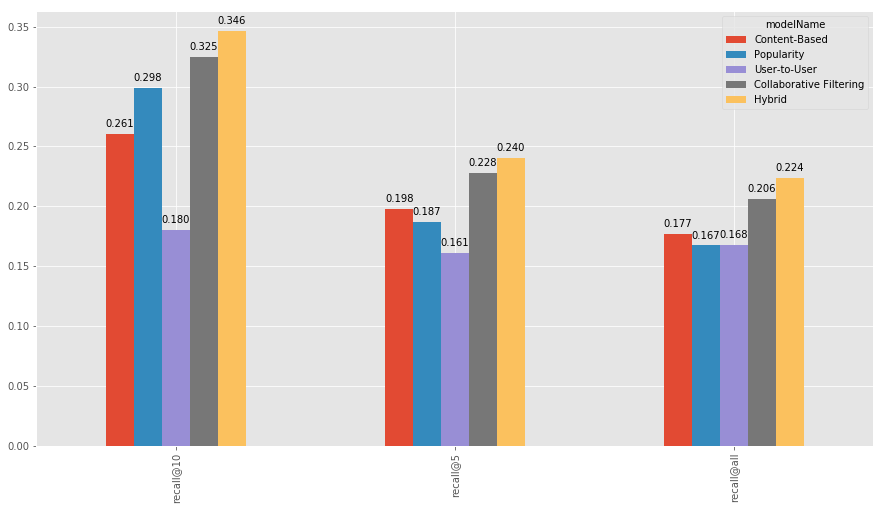

In [119]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [120]:
pop_summary['model'] = 'popularity'
cb_summary['model'] = 'content based'
ucf_summary['model'] = 'user to user'
cf_summary['model'] = 'collaborative filtering'
hybrid_summary['model'] = 'hybrid'

total_summary = pop_summary.append([cb_summary, ucf_summary, cf_summary, hybrid_summary])
total_summary

,order,interaction_category,_person_id,recall@10,recall@5,recall@all,interacted_in_test_avg,model
0,1,1,257,0.303502,0.241245,0.229572,1.000000,popularity
1,2,2,24,0.333333,0.291667,0.250000,1.000000,popularity
2,3,3 to 5,307,0.286645,0.208469,0.182410,1.000000,popularity
3,4,6 to 10,121,0.359504,0.223140,0.202479,1.595041,popularity
4,5,11 to 50,88,0.268290,0.145148,0.146677,4.431818,popularity
5,6,More than 50,36,0.316667,0.161111,0.122222,10.000000,popularity
0,7,Total,833,0.298498,0.186806,0.167211,1.837935,popularity
0,1,1,257,0.303502,0.241245,0.229572,1.000000,content based
1,2,2,24,0.291667,0.291667,0.250000,1.000000,content based
2,3,3 to 5,307,0.312704,0.257329,0.218241,1.000000,content based


In [121]:
tot = total_summary.pivot_table(index = ['order', 'interaction_category'], columns = 'model', values = 'recall@10')
tot.index = tot.index.get_level_values(1)
tot

model,collaborative filtering,content based,hybrid,popularity,user to user
interaction_category,,,,,
1,0.303502,0.303502,0.303502,0.303502,0.303502
2,0.291667,0.291667,0.291667,0.333333,0.250000
3 to 5,0.338762,0.312704,0.397394,0.286645,0.185668
6 to 10,0.404959,0.268595,0.433884,0.359504,0.231405
11 to 50,0.325189,0.253111,0.337879,0.268290,0.156070
More than 50,0.297222,0.208333,0.308333,0.316667,0.105556
Total,0.324624,0.260614,0.346179,0.298498,0.180274


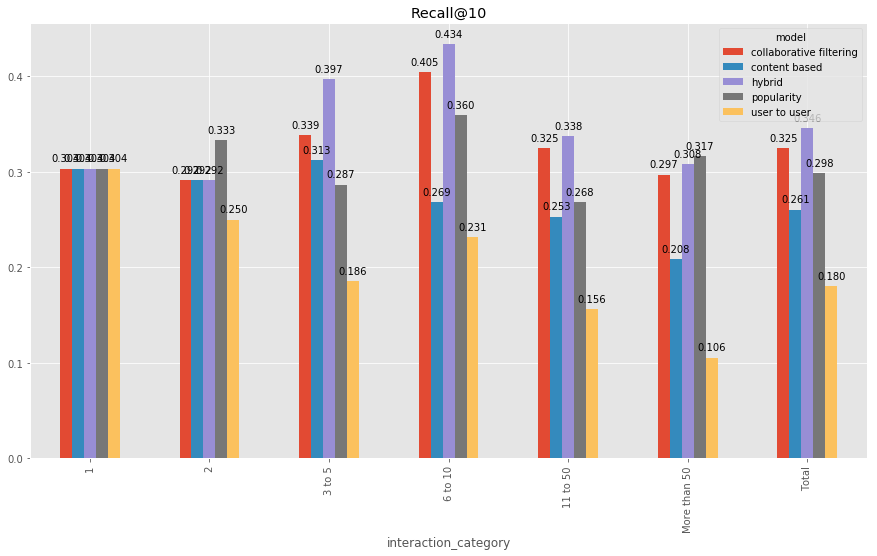

In [122]:
%matplotlib inline
ax = tot.plot(kind='bar', figsize=(15,8))
ax.title.set_text('Recall@10')
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [123]:
tot = total_summary.pivot_table(index = ['order', 'interaction_category'], columns = 'model', values = 'recall@all')
tot.index = tot.index.get_level_values(1)
tot

model,collaborative filtering,content based,hybrid,popularity,user to user
interaction_category,,,,,
1,0.229572,0.229572,0.229572,0.229572,0.229572
2,0.166667,0.250000,0.208333,0.250000,0.250000
3 to 5,0.221498,0.218241,0.267101,0.182410,0.185668
6 to 10,0.235537,0.202479,0.305785,0.202479,0.231405
11 to 50,0.191955,0.176114,0.203950,0.146677,0.156070
More than 50,0.188889,0.113889,0.186111,0.122222,0.105556
Total,0.206401,0.177008,0.224037,0.167211,0.167864


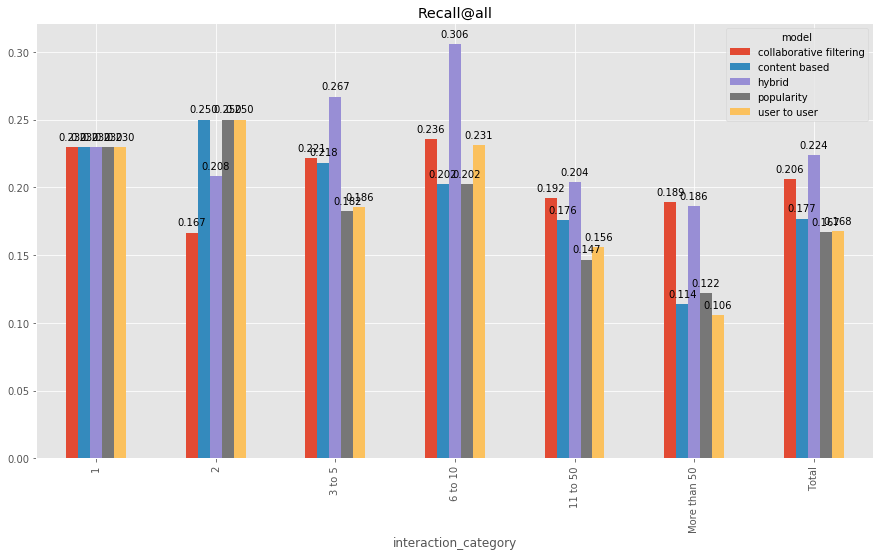

In [124]:
%matplotlib inline
ax = tot.plot(kind='bar', figsize=(15,8))
ax.title.set_text('Recall@all')
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [ ]:
popularity_model.recommend_items(user_id = 'dummy', items_to_ignore=[], topn=10, verbose=False)

In [ ]:
item_popularity_df.head(10)